In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn nos ofrece una variedad ampliada de modelos Naive Bayes, para este problema usamos MultinomialNB que es pensado para este tipo de problemas
from sklearn.naive_bayes import MultinomialNB   

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# TP3: Detector de SPAM

Uno de los problemas más comunes en la clasificación es la detección de correos electrónicos SPAM. Uno de los primeros modelos utilizados para abordar este problema fue el clasificador de Bayes ingenuo. La detección de SPAM es un problema persistente en el mundo digital, ya que los spammers continúan adaptando sus estrategias para eludir los filtros de correo no deseado. Además del clasificador de Bayes ingenuo, se han desarrollado y utilizado una variedad de técnicas más avanzadas en la detección de SPAM, que incluyen algoritmos de aprendizaje automático, redes neuronales y métodos basados en reglas.

En este trabajo práctico, utilizaremos un conjunto de datos que consta de 4601 observaciones de correos electrónicos, de los cuales 2788 son correos legítimos y 1813 son correos SPAM. Dado que el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo de alguna manera. Para este conjunto de datos, ya se ha aplicado un procesamiento típico en el Procesamiento del Lenguaje Natural (NLP), que consiste en contar la frecuencia de palabras observadas en los correos.

El procesamiento de lenguaje natural (NLP) desempeña un papel fundamental en la detección de SPAM, ya que permite analizar el contenido de los correos electrónicos y extraer características relevantes para la clasificación. Además de contar la frecuencia de palabras, se pueden utilizar técnicas más sofisticadas, como la extracción de características semánticas y el análisis de sentimientos, para mejorar la precisión de los modelos de detección de SPAM.

En este proceso, se cuenta la cantidad de ocurrencias de cada palabra en los diferentes correos.

![spam counter](./spam.png)

Con el fin de preservar la privacidad de los mensajes, la frecuencia de palabras se encuentra normalizada. El conjunto de datos está compuesto por 54 columnas de atributos que se denominan:

- `word_freq_XXXX`: Donde `XXXX` es la palabra o símbolo. Los valores son enteros que van de 0 a 20k.

Además, hay una columna adicional llamada `spam`, que es 1 si el correo es SPAM o 0 si no lo es.

Los clasificadores de Bayes ingenuos fueron los primeros filtros utilizados por las aplicaciones de correo electrónico, basados en este principio de palabras. La idea es que, partiendo de un dato a priori sobre la probabilidad de que un correo sea SPAM o no, ciertas palabras nos indicarán que la probabilidad a posteriori, dadas esas palabras, es más probable que el correo sea SPAM o no.

# 1. Lectura y exploración de los datos

In [3]:
dataset = pd.read_csv("dataset/spambase.csv") # cargando los datos desde un CSV
dataset.head(10)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1
5,0,0,0,0,1850,0,0,1850,0,0,...,0,0,0,0,223,0,0,0,0,1
6,0,0,0,0,1920,0,0,0,0,640,...,0,0,0,0,54,0,164,54,0,1
7,0,0,0,0,1880,0,0,1880,0,0,...,0,0,0,0,206,0,0,0,0,1
8,150,0,460,0,610,0,300,0,920,760,...,0,0,0,0,271,0,181,203,22,1
9,60,120,770,0,190,320,380,0,60,0,...,0,0,0,40,30,0,244,81,0,1


Para obtener las palábras más usadas podemos hacer un `groupby`:

In [4]:
column_sum = dataset.groupby(by="spam", as_index=False).sum()

Y despues se pueden combinar las columnas en usando [pd.melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html)

In [5]:
# Obtenemos los atributos y target
X = (dataset.drop(columns="spam") * 100).astype(int)
#X = dataset2.drop(columns="spam")
y = dataset["spam"]

# 2. Identificar las 10 palabras más comunes en correos SPAM y No SPAM
Vamos a agrupar los correos SPAM y No SPAM y contar las palabras más frecuentes en cada grupo.

In [9]:
# Separar correos SPAM y No SPAM
spam_emails = dataset[dataset['spam'] == 1]
non_spam_emails = dataset[dataset['spam'] == 0]

# Calcular la frecuencia de cada palabra en SPAM y No SPAM
spam_word_freq = spam_emails.drop(columns=['spam']).sum().sort_values(ascending=False)
non_spam_word_freq = non_spam_emails.drop(columns=['spam']).sum().sort_values(ascending=False)

# Obtener las 10 palabras más frecuentes en cada grupo
top_10_spam = spam_word_freq.head(10)
top_10_non_spam = non_spam_word_freq.head(10)

print("Top 10 palabras en SPAM:")
print(top_10_spam)
print("\nTop 10 palabras en No SPAM:")
print(top_10_non_spam)

Top 10 palabras en SPAM:
word_freq_you         4105599
word_freq_your        2502597
word_freq_will         997100
word_freq_free         939790
word_freq_our          931799
char_freq_!            931352
word_freq_all          732080
word_freq_mail         635470
word_freq_email        578759
word_freq_business     521250
dtype: int64

Top 10 palabras en No SPAM:
word_freq_you        3541702
word_freq_george     3527559
word_freq_hp         2496576
word_freq_will       1495268
word_freq_your       1223098
word_freq_hpl        1204398
word_freq_re         1159138
word_freq_edu         800669
word_freq_address     681569
word_freq_meeting     604460
dtype: int64


# 3. Separar el conjunto de datos en entrenamiento y prueba (70% y 30%)
Usaremos train_test_split de Scikit-learn para dividir el conjunto de datos.

In [6]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3)

Escalamos para aplicar en regresión logística

In [10]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformamos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Conjunto de entrenamiento:", X_train_scaled.shape)
print("Conjunto de prueba:", X_test_scaled.shape)

Conjunto de entrenamiento: (3220, 54)
Conjunto de prueba: (1381, 54)


# 4. Entrenar un clasificador de Bayes ingenuo
Utilizaremos MultinomialNB de Scikit-learn.

In [13]:
from sklearn.naive_bayes import MultinomialNB

# Entrenar el modelo de Bayes ingenuo
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)



MultinomialNB()

# 5. Entrenar un clasificador de Regresión Logística
Utilizamos los datos normalizado y usaremos LogisticRegression.

In [14]:
# Entrenar el modelo de Regresión Logística
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

# 6. Calcular la matriz de confusión para ambos modelos
Usaremos confusion_matrix de Scikit-learn.

In [15]:
from sklearn.metrics import confusion_matrix

# Predicciones
nb_predictions = nb_model.predict(X_test)
lr_predictions = lr_model.predict(X_test_scaled)

# Matriz de confusión
nb_cm = confusion_matrix(y_test, nb_predictions)
lr_cm = confusion_matrix(y_test, lr_predictions)

print("Matriz de confusión - Bayes ingenuo:")
print(nb_cm)
print("\nMatriz de confusión - Regresión Logística:")
print(lr_cm)


Matriz de confusión - Bayes ingenuo:
[[683 173]
 [ 20 505]]

Matriz de confusión - Regresión Logística:
[[804  52]
 [112 413]]


# 7. Calcular precisión y recuperación de ambos modelos
Usaremos classification_report de Scikit-learn para obtener precisión y recuperación.

In [17]:
from sklearn.metrics import classification_report

# Reporte de clasificación
nb_report = classification_report(y_test, nb_predictions, target_names=['No SPAM', 'SPAM'])
lr_report = classification_report(y_test, lr_predictions, target_names=['No SPAM', 'SPAM'])

print("Reporte de clasificación - Bayes ingenuo:")
print(nb_report)
print("\nReporte de clasificación - Regresión Logística:")
print(lr_report)


Reporte de clasificación - Bayes ingenuo:
              precision    recall  f1-score   support

     No SPAM       0.97      0.80      0.88       856
        SPAM       0.74      0.96      0.84       525

    accuracy                           0.86      1381
   macro avg       0.86      0.88      0.86      1381
weighted avg       0.89      0.86      0.86      1381


Reporte de clasificación - Regresión Logística:
              precision    recall  f1-score   support

     No SPAM       0.88      0.94      0.91       856
        SPAM       0.89      0.79      0.83       525

    accuracy                           0.88      1381
   macro avg       0.88      0.86      0.87      1381
weighted avg       0.88      0.88      0.88      1381



# 8. Obtener la curva ROC y el AUC de ambos modelos
Usaremos roc_curve y roc_auc_score de Scikit-learn.

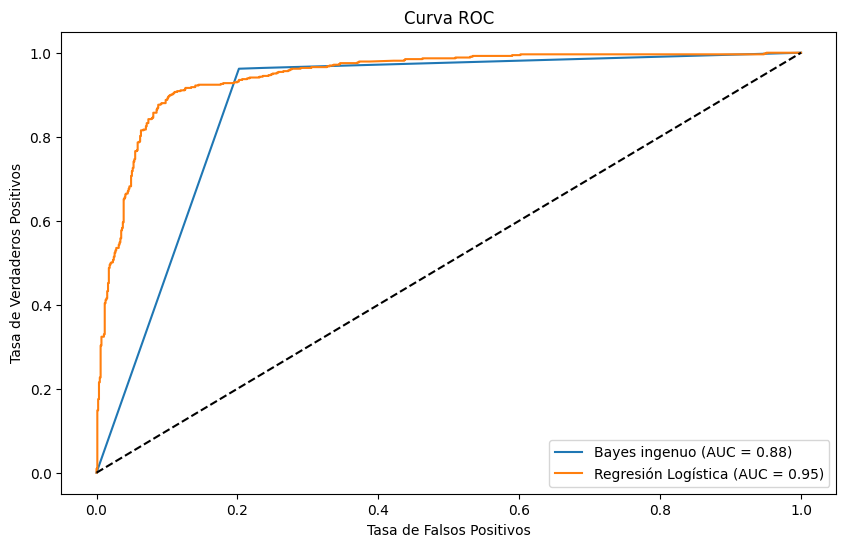

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular probabilidades
nb_prob = nb_model.predict_proba(X_test)[:, 1]
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

# Curvas ROC
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_prob)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)

# Calcular AUC
nb_auc = roc_auc_score(y_test, nb_prob)
lr_auc = roc_auc_score(y_test, lr_prob)

# Graficar curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(nb_fpr, nb_tpr, label=f'Bayes ingenuo (AUC = {nb_auc:.2f})')
plt.plot(lr_fpr, lr_tpr, label=f'Regresión Logística (AUC = {lr_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()
